In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

import pickle

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_pickle("all_recipes.pkl")
df2=pd.read_pickle("all_users.pkl")
df.head()

,calories,category,ingredients,ratings,recipe_id,reviews,title,total_mins,Season,DaytimeOfCooking,Veg/NonVeg
0,728,"['Desserts', 'Fruit Desserts', 'Pineapple Dess...","['2 cups all-purpose flour', '1 teaspoon salt'...",4.703704,263516,23,Chef John's Carrot Cake,95,Fall/Winter,Dessert,Non-Veg (Eggs)
1,692,"['Bread', 'Yeast Bread']","['1/2 cup warm milk', '1/3 cup warm water', '1...",4.666667,272625,2,Khachapuri (Georgian Cheese Bread),115,Any,Lunch/Dinner,Non-Veg (Cheese)
2,209,"['Soups, Stews and Chili', 'Stews', 'Beef']","['1 (1 1/2-pound) flank steak', '2 teaspoons k...",5.000000,272615,4,Ropa Vieja (Cuban Beef),690,Any,Dinner,Non-Veg (Beef)
3,505,"['Everyday Cooking', 'Vegetarian', 'Side Dishes']","['2 cups whole milk', '1 teaspoon kosher salt,...",4.333333,272461,9,"""Instant"" Mac and Cheese",28,Any,Lunch/Dinner,Veg
4,291,"['Bread', 'Yeast Bread']","['1 cup warm water', '1 tablespoon white sugar...",5.000000,271049,4,Kouign-Amann,275,Any,Dessert,Non-Veg (Butter)


In [3]:
df2.head()

,date,rating,recipe_id,review,user_id,username
0,2012-09-11,5,222234,This recipe was delicious! Instead of cherry p...,3419993,Pie84
1,2012-12-25,5,222234,Made this recipe as instructed and it was easy...,3154459,hertzen
2,2012-11-22,5,222234,This was a great recipe to make using leftover...,10370475,suziloo
3,2015-07-07,5,222234,"Tasty , simple dessert that comes out cute as ...",2304335,Chelsea M.
4,2016-12-31,5,222234,"Delicious!! I was pressed for time, so I didn'...",1967176,Amanda H.


In [4]:
null_records = df[df.isnull().any(axis=1)]
print(null_records)

    calories                                           category  \
748        0                                                NaN   
753        0                                                NaN   
755        0                                                NaN   
756        0                                                NaN   
774        0                                                NaN   
776      135  ['Appetizers and Snacks', 'Dips and Spreads', ...   
779        0                                                NaN   
784        0                                                NaN   
786        0                                                NaN   
794        0                                                NaN   
804        0                                                NaN   
811        0                                                NaN   
812        0                                                NaN   

                                           ingredients   rati

We Find one record which has a Null Attribute that can be filled manually with relevant data. 

In [197]:
df.at[776, 'Veg/NonVeg'] = 'Non-Veg'

Rest of the Null Attributes are beyond repair. so we drop them from the dataset for better model functionality.

In [6]:
df = df.dropna()
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   calories          1162 non-null   object 
 1   category          1162 non-null   object 
 2   ingredients       1162 non-null   object 
 3   ratings           1162 non-null   float64
 4   recipe_id         1162 non-null   int64  
 5   reviews           1162 non-null   object 
 6   title             1162 non-null   object 
 7   total_mins        1162 non-null   int64  
 8   Season            1162 non-null   object 
 9   DaytimeOfCooking  1162 non-null   object 
 10  Veg/NonVeg        1162 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 100.0+ KB


In [7]:
df2.dropna()
df2.drop_duplicates(inplace=True)
df2=df2.reset_index(drop=True)

def processing(value):
    return int(value)

df2['rating']=df2['rating'].apply(processing)
df2['recipe_id']=df2['recipe_id'].apply(processing)
df2['user_id']=df2['user_id'].apply(processing)

df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

**CONVERTING THE FEATURES TO RELEVANT DATATYPE - REVIEWS, CALORIES, CATEGORY, INGREDIENTS**

In [8]:
def replace_k(value):
    if 'k' in value:
        value=str(value).split('k')
        value=value[0]
        value=float(value)*1000
    return value

df['reviews']=df['reviews'].apply(replace_k)

def cat_2(value):
    return eval(value)

df['category']=df['category'].apply(cat_2)
df['ingredients']=df['ingredients'].apply(cat_2)

df['reviews']=df['reviews'].apply(processing)

def calories(value):
    if value.isdigit():
        return int(value)
    else:
        return 1
df['calories']=df['calories'].apply(calories)

df = df.rename(columns={'ratings': 'avg_rating', 'reviews':'no_reviews', 'Season':'season','DaytimeOfCooking':'meal_type','Veg/NonVeg':'diet_type'})

df.head()

,calories,category,ingredients,avg_rating,recipe_id,no_reviews,title,total_mins,season,meal_type,diet_type
0,728,"[Desserts, Fruit Desserts, Pineapple Desserts]","[2 cups all-purpose flour, 1 teaspoon salt, 1 ...",4.703704,263516,23,Chef John's Carrot Cake,95,Fall/Winter,Dessert,Non-Veg (Eggs)
1,692,"[Bread, Yeast Bread]","[1/2 cup warm milk, 1/3 cup warm water, 1 1/2 ...",4.666667,272625,2,Khachapuri (Georgian Cheese Bread),115,Any,Lunch/Dinner,Non-Veg (Cheese)
2,209,"[Soups, Stews and Chili, Stews, Beef]","[1 (1 1/2-pound) flank steak, 2 teaspoons kosh...",5.000000,272615,4,Ropa Vieja (Cuban Beef),690,Any,Dinner,Non-Veg (Beef)
3,505,"[Everyday Cooking, Vegetarian, Side Dishes]","[2 cups whole milk, 1 teaspoon kosher salt, or...",4.333333,272461,9,"""Instant"" Mac and Cheese",28,Any,Lunch/Dinner,Veg
4,291,"[Bread, Yeast Bread]","[1 cup warm water, 1 tablespoon white sugar, 1...",5.000000,271049,4,Kouign-Amann,275,Any,Dessert,Non-Veg (Butter)


In [9]:
df['season'] = df['season'].apply(lambda x: x.split('/'))
df['season'] = df['season'].apply(lambda x: ['Summer', 'Spring', 'Fall', 'Winter'] if x == ['Any'] else x)
df['meal_type'] = df['meal_type'].apply(lambda x: x.split('/'))

In [10]:
def count_ingredients(ingredients):
    return len(ingredients)

df['no_ingredients'] = df['ingredients'].apply(count_ingredients)
df.head()

,calories,category,ingredients,avg_rating,recipe_id,no_reviews,title,total_mins,season,meal_type,diet_type,no_ingredients
0,728,"[Desserts, Fruit Desserts, Pineapple Desserts]","[2 cups all-purpose flour, 1 teaspoon salt, 1 ...",4.703704,263516,23,Chef John's Carrot Cake,95,"[Fall, Winter]",[Dessert],Non-Veg (Eggs),18
1,692,"[Bread, Yeast Bread]","[1/2 cup warm milk, 1/3 cup warm water, 1 1/2 ...",4.666667,272625,2,Khachapuri (Georgian Cheese Bread),115,"[Summer, Spring, Fall, Winter]","[Lunch, Dinner]",Non-Veg (Cheese),14
2,209,"[Soups, Stews and Chili, Stews, Beef]","[1 (1 1/2-pound) flank steak, 2 teaspoons kosh...",5.000000,272615,4,Ropa Vieja (Cuban Beef),690,"[Summer, Spring, Fall, Winter]",[Dinner],Non-Veg (Beef),24
3,505,"[Everyday Cooking, Vegetarian, Side Dishes]","[2 cups whole milk, 1 teaspoon kosher salt, or...",4.333333,272461,9,"""Instant"" Mac and Cheese",28,"[Summer, Spring, Fall, Winter]","[Lunch, Dinner]",Veg,10
4,291,"[Bread, Yeast Bread]","[1 cup warm water, 1 tablespoon white sugar, 1...",5.000000,271049,4,Kouign-Amann,275,"[Summer, Spring, Fall, Winter]",[Dessert],Non-Veg (Butter),10


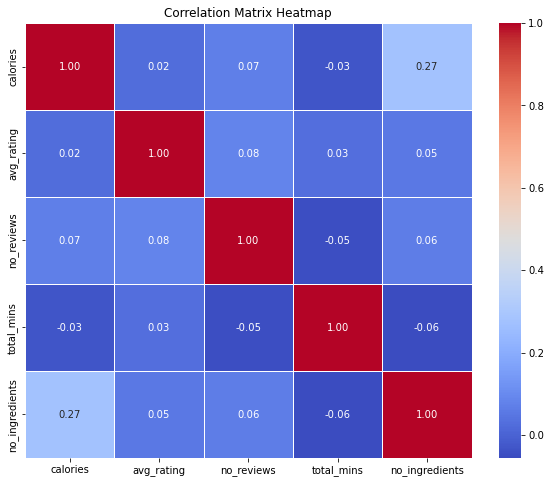

In [11]:
num_features = df[['calories', 'avg_rating', 'no_reviews', 'total_mins', 'no_ingredients']]
plt.figure(figsize=(10, 8))
corr_matrix = num_features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [12]:
pattern = re.compile(r'\s*\([^)]*\)')
records = df['diet_type']

cleaned_records = [re.sub(pattern, '', record) for record in records]
df['diet_type'] = cleaned_records

In [13]:
def clean_text(text):
    text = text.lower()
    nopunct_text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    tokens = word_tokenize(nopunct_text)
    return tokens[0]

df['diet_type'] = df['diet_type'].apply(clean_text)
df.head()

,calories,category,ingredients,avg_rating,recipe_id,no_reviews,title,total_mins,season,meal_type,diet_type,no_ingredients
0,728,"[Desserts, Fruit Desserts, Pineapple Desserts]","[2 cups all-purpose flour, 1 teaspoon salt, 1 ...",4.703704,263516,23,Chef John's Carrot Cake,95,"[Fall, Winter]",[Dessert],nonveg,18
1,692,"[Bread, Yeast Bread]","[1/2 cup warm milk, 1/3 cup warm water, 1 1/2 ...",4.666667,272625,2,Khachapuri (Georgian Cheese Bread),115,"[Summer, Spring, Fall, Winter]","[Lunch, Dinner]",nonveg,14
2,209,"[Soups, Stews and Chili, Stews, Beef]","[1 (1 1/2-pound) flank steak, 2 teaspoons kosh...",5.000000,272615,4,Ropa Vieja (Cuban Beef),690,"[Summer, Spring, Fall, Winter]",[Dinner],nonveg,24
3,505,"[Everyday Cooking, Vegetarian, Side Dishes]","[2 cups whole milk, 1 teaspoon kosher salt, or...",4.333333,272461,9,"""Instant"" Mac and Cheese",28,"[Summer, Spring, Fall, Winter]","[Lunch, Dinner]",veg,10
4,291,"[Bread, Yeast Bread]","[1 cup warm water, 1 tablespoon white sugar, 1...",5.000000,271049,4,Kouign-Amann,275,"[Summer, Spring, Fall, Winter]",[Dessert],nonveg,10


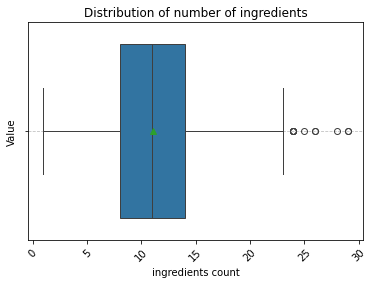

In [14]:
sns.boxplot(x="no_ingredients", showmeans=True, data=df)

plt.title("Distribution of number of ingredients")
plt.xlabel("ingredients count")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.8)

plt.show()

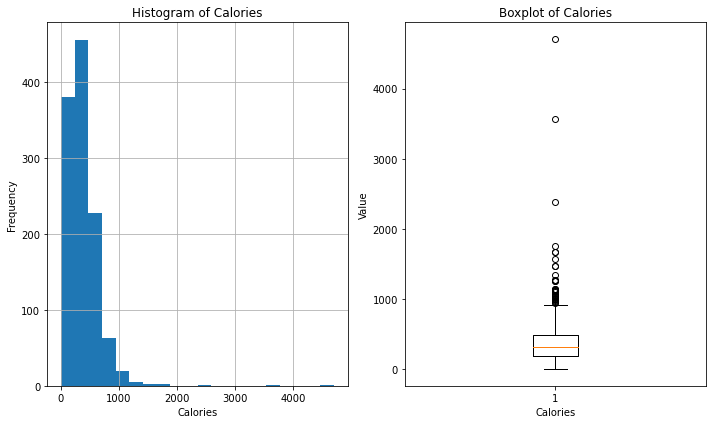

Mean calories: 375.97848537005166
Median calories: 317.0
Skewness: 4.858384005910365
Number of outliers (high): 35


In [15]:
calories = df["calories"]

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
calories.hist(bins=20)
plt.xlabel("Calories")
plt.ylabel("Frequency")
plt.title("Histogram of Calories")

plt.subplot(1, 2, 2)
plt.boxplot(calories)
plt.xlabel("Calories")
plt.ylabel("Value")
plt.title("Boxplot of Calories")

plt.tight_layout()
plt.show()

# Identify outliers (consider IQR method)
q1 = calories.quantile(0.25)
q3 = calories.quantile(0.75)
iqr = q3 - q1
outliers_low = calories[calories < (q1 - 1.5 * iqr)]
outliers_high = calories[calories > (q3 + 1.5 * iqr)]

# Print the results
print("Mean calories:", calories.mean())
print("Median calories:", calories.median())
print("Skewness:", calories.skew())

if len(outliers_low) > 0:
  print("Number of outliers (low):", len(outliers_low))
if len(outliers_high) > 0:
  print("Number of outliers (high):", len(outliers_high))


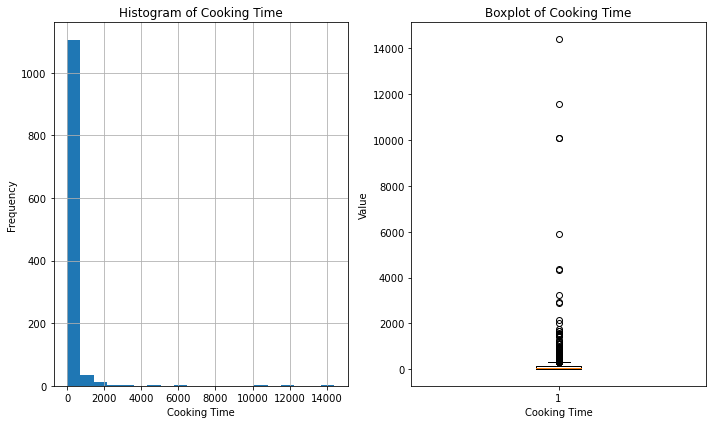

Mean Cooking Time: 194.44406196213424
Median Cooking Time: 55.0
Skewness: 12.672269391034833
Number of outliers (high): 121


In [16]:
time = df["total_mins"]

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
time.hist(bins=20)
plt.xlabel("Cooking Time")
plt.ylabel("Frequency")
plt.title("Histogram of Cooking Time")

plt.subplot(1, 2, 2)
plt.boxplot(time)
plt.xlabel("Cooking Time")
plt.ylabel("Value")
plt.title("Boxplot of Cooking Time")

plt.tight_layout()
plt.show()

# Identify outliers (consider IQR method)
q1 = time.quantile(0.25)
q3 = time.quantile(0.75)
iqr = q3 - q1
outliers_low = time[time < (q1 - 1.5 * iqr)]
outliers_high = time[time > (q3 + 1.5 * iqr)]

# Print the results
print("Mean Cooking Time:", time.mean())
print("Median Cooking Time:", time.median())
print("Skewness:", time.skew())

if len(outliers_low) > 0:
    print("Number of outliers (low):", len(outliers_low))
if len(outliers_high) > 0:
    print("Number of outliers (high):", len(outliers_high))


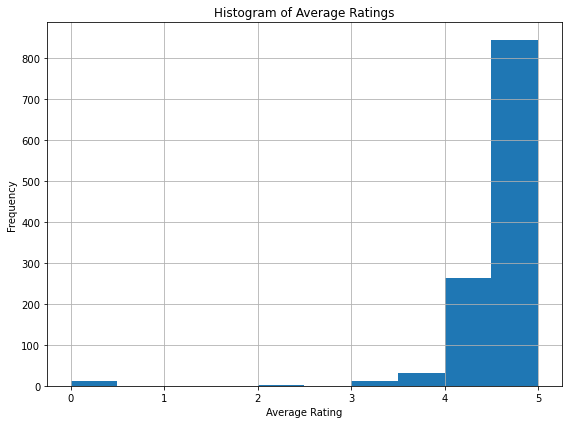

Descriptive Statistics:
count    1162.000000
mean        4.544060
std         0.558952
min         0.000000
25%         4.458333
50%         4.659545
75%         4.803826
max         5.000000
Name: avg_rating, dtype: float64


In [17]:
avg_ratings = df["avg_rating"]

# Visualize the distribution using histograms or boxplots
plt.figure(figsize=(8, 6))

plt.subplot(1, 1, 1)
avg_ratings.hist(bins=10)
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Average Ratings")

plt.tight_layout()
plt.show()

# Explore descriptive statistics (optional)
print("Descriptive Statistics:")
print(avg_ratings.describe())


In [18]:
# Define a threshold for identifying significant outliers (e.g., 3 standard deviations above the mean)
threshold = 3 * df['total_mins'].std()

# Filter the dataset to include only records with cooking times exceeding the threshold
outliers_df = df[df['total_mins'] > threshold]

# Print the records with significant outlier cooking times
print(outliers_df)

      calories                                           category  \
975        158                            [Seafood, Fish, Salmon]   
980        790               [Main Dish, Pork, Pork Chops, Baked]   
991        484                 [Meat and Poultry, Pork, Shoulder]   
993        316              [Bread, Yeast Bread, Sourdough Bread]   
994         12  [Side Dish, Sauces and Condiments, Canning and...   
997         48  [Appetizers and Snacks, Dips and Spreads, Chee...   
998        120                                                 []   
1039        16                 [Side Dish, Sauces and Condiments]   
1059        52         [Side Dish, Sauces and Condiments, Sauces]   
1148        23                 [Side Dish, Sauces and Condiments]   

                                            ingredients  avg_rating  \
975   [1/4 cup kosher salt, 1/4 cup white sugar, 1 p...    5.000000   
980   [Brine:, 1 1/2 cups boiling water, 3/4 cup pac...    4.600000   
991   [1 (7 pound) fresh, b

In [19]:
df.describe()

,calories,avg_rating,recipe_id,no_reviews,total_mins,no_ingredients
count,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000
mean,375.978485,4.544060,239943.815835,62.666093,194.444062,11.092943
std,295.153220,0.558952,15251.066547,133.848245,771.197728,4.601423
min,1.000000,0.000000,219075.000000,0.000000,0.000000,1.000000
25%,194.000000,4.458333,228643.250000,8.000000,25.000000,8.000000
50%,317.000000,4.659545,237471.500000,22.000000,55.000000,11.000000
75%,489.750000,4.803826,254277.750000,54.000000,140.000000,14.000000
max,4709.000000,5.000000,273495.000000,2000.000000,14415.000000,29.000000


In [20]:
df.describe(include="object").T

,count,unique,top,freq
category,1162,440,"[World Cuisine, European, Italian]",58
ingredients,1162,1156,"[2 cups all-purpose flour, 1 teaspoon salt, 1 ...",2
title,1162,1150,Chef John's Carrot Cake,2
season,1162,9,"[Summer, Spring, Fall, Winter]",883
meal_type,1162,59,[Dinner],445
diet_type,1162,2,veg,593


**OUTLIERS REMOVAL USING IQR METHOD**

IQR is a robust statistical measure that represents the spread of the middle 50% of the data. It's calculated as the difference between the third quartile (Q3) and the first quartile (Q1).
In recipe recommendation, outliers could be recipes with:

    Extremely high or low cooking time.
    Extremely high or low calories.
    Unusually large or small numbers of ingredients.

In [21]:
def iqr_method(outlier):
    #Removing Outliers by IQR Method
    q1=df[outlier].quantile(0.25)
    q3=df[outlier].quantile(0.75)
    iqr=q3-q1
    upper_limit = q3 + (1.5*iqr)
    lower_limit = q1 - (1.5*iqr)
    
    df.loc[(df[outlier]>upper_limit),outlier]=upper_limit
    df.loc[(df[outlier]<lower_limit),outlier]=lower_limit
iqr_method('calories')
iqr_method('no_ingredients')
iqr_method('total_mins')

/tmp/ipykernel_17709/2791429900.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '933.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[outlier]>upper_limit),outlier]=upper_limit
/tmp/ipykernel_17709/2791429900.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '312.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[outlier]>upper_limit),outlier]=upper_limit


<AxesSubplot:ylabel='calories'>

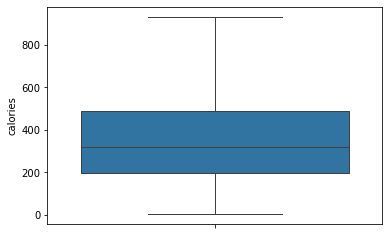

In [22]:
sns.boxplot(df['calories'])

<AxesSubplot:ylabel='no_ingredients'>

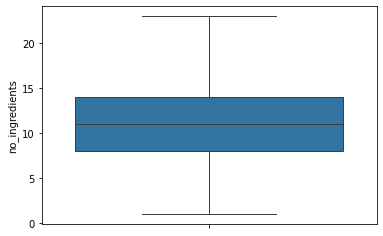

In [23]:
sns.boxplot(df['no_ingredients'])

<AxesSubplot:ylabel='total_mins'>

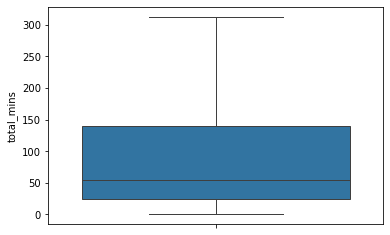

In [24]:
sns.boxplot(df['total_mins'])

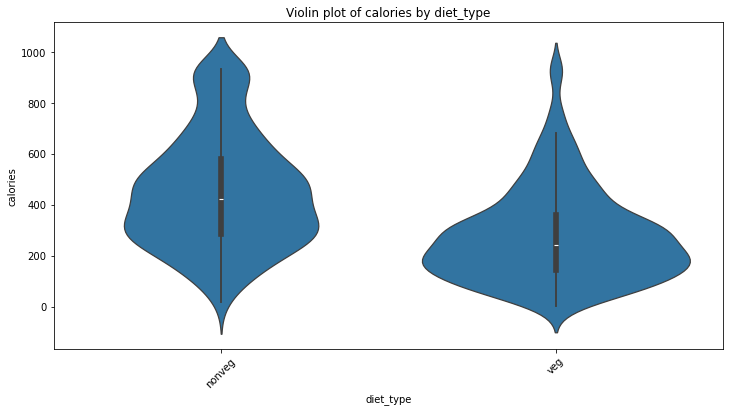

In [25]:
categorical_features = ['diet_type']
numerical_feature = 'calories'

for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.violinplot(x=feature, y=numerical_feature, data=df)
    plt.title(f'Violin plot of {numerical_feature} by {feature}')
    plt.xlabel(feature)
    plt.ylabel(numerical_feature)
    plt.xticks(rotation=45)
    plt.show()

In [26]:
df_exploded = df.explode('season')
df_exploded2 = df.explode('meal_type')

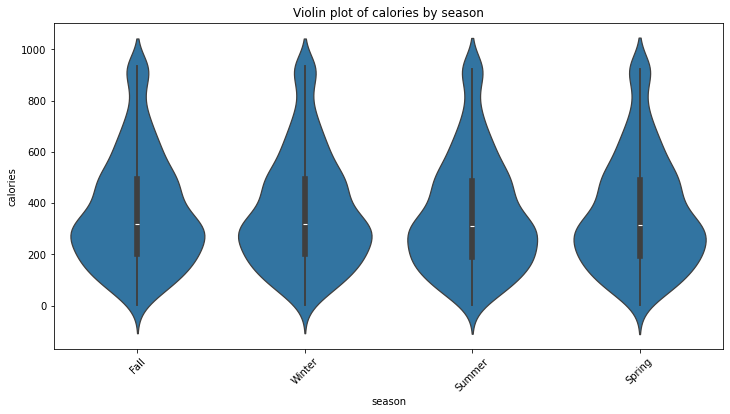

In [27]:
categorical_features = ['season']
numerical_feature = 'calories'

for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.violinplot(x=feature, y=numerical_feature, data=df_exploded)
    plt.title(f'Violin plot of {numerical_feature} by {feature}')
    plt.xlabel(feature)
    plt.ylabel(numerical_feature)
    plt.xticks(rotation=45)
    plt.show()

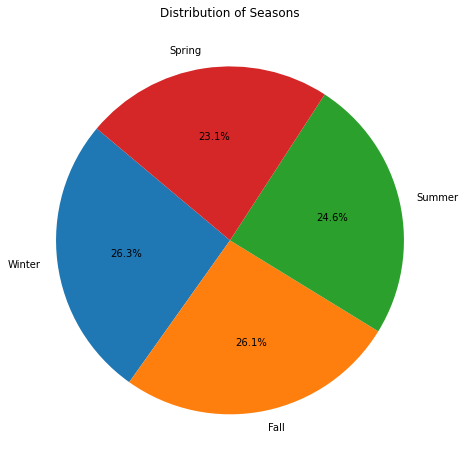

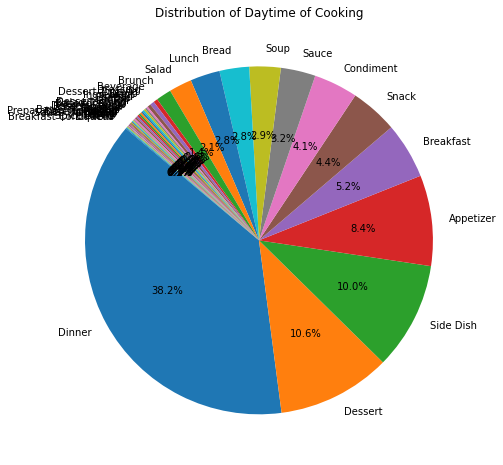

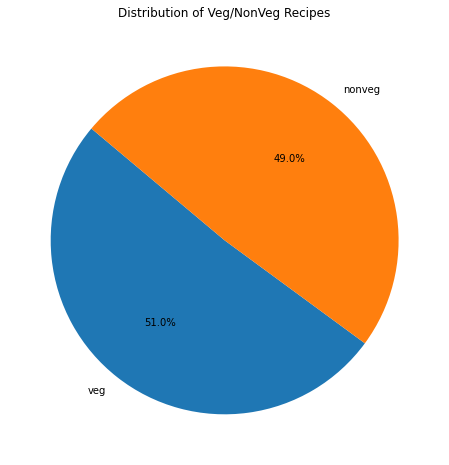

In [28]:
def plot_pie_chart(data, column, title):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()
plot_pie_chart(df_exploded, 'season', 'Distribution of Seasons')
plot_pie_chart(df_exploded2, 'meal_type', 'Distribution of Daytime of Cooking')
plot_pie_chart(df, 'diet_type', 'Distribution of Veg/NonVeg Recipes')

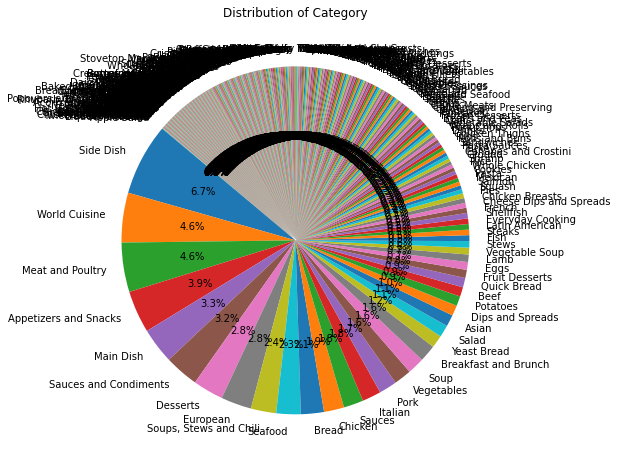

In [188]:
plot_pie_chart(df_exploded3, 'category', 'Distribution of Category')

**since there are a lot of categories, we take out the top 50 frequently occuring categories of recipes**

In [196]:
df_exploded3 = df.explode('category')
print(len(df_exploded3['category'].unique()))
category_counts = df_exploded3['category'].value_counts()
category_counts.head(50)

461


category
Side Dish                  222
World Cuisine              153
Meat and Poultry           152
Appetizers and Snacks      130
Main Dish                  110
Sauces and Condiments      105
Desserts                    94
European                    94
Soups, Stews and Chili      78
Seafood                     75
Bread                       71
Chicken                     62
Sauces                      61
Italian                     58
Pork                        55
Vegetables                  54
Soup                        52
Breakfast and Brunch        52
Yeast Bread                 39
Salad                       37
Asian                       36
Dips and Spreads            32
Potatoes                    30
Beef                        29
Quick Bread                 29
Fruit Desserts              25
Eggs                        24
Lamb                        23
Vegetable Soup              21
Stews                       20
Fish                        18
Steaks                      17

In [193]:
x = category_counts.head(50)
y = x.index.tolist()
print(y)

filtered_df = df_exploded3[df_exploded3['category'].isin(y)]

['Side Dish', 'World Cuisine', 'Meat and Poultry', 'Appetizers and Snacks', 'Main Dish', 'Sauces and Condiments', 'Desserts', 'European', 'Soups, Stews and Chili', 'Seafood', 'Bread', 'Chicken', 'Sauces', 'Italian', 'Pork', 'Vegetables', 'Soup', 'Breakfast and Brunch', 'Yeast Bread', 'Salad', 'Asian', 'Dips and Spreads', 'Potatoes', 'Beef', 'Quick Bread', 'Fruit Desserts', 'Eggs', 'Lamb', 'Vegetable Soup', 'Stews', 'Fish', 'Steaks', 'Latin American', 'Everyday Cooking', 'Shellfish', 'French', 'Cheese Dips and Spreads', 'Chicken Breasts', 'Pies', 'Squash', 'Salmon', 'Mexican', 'Pasta', 'Cookies', 'Whole Chicken', 'Rice', 'Shrimp', 'Ground', 'Canapes and Crostini', 'Turkey']


**remapping the categories to recipes and checking how many recipes fall under the top 50 categories:**

In [195]:
print("Filtered DataFrame:")
print(len(filtered_df['recipe_id'].unique()))

Filtered DataFrame:
1136


**1136 out of 1162 recipes are mapped under the top 50 categories.**

**we have filtered out 50 categories from 461 unique categories**